# DLS Reading Python Code

# Import packages

In [367]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import calendar
from scipy.optimize import curve_fit
#from google.colab import drive
#drive.mount('/content/drive')

# Load Data

In [368]:
#df = pd.read_excel('/Users/alison/Library/CloudStorage/GoogleDrive-alui@berkeley.edu/My Drive/Research/AL Data/B3P170 - R18 and CF LUV + LNP/2023-07-27 - DLS/2023-07-27 lnp.xlsx')
df = pd.read_excel('/Users/alison/Library/CloudStorage/GoogleDrive-alui@berkeley.edu/My Drive/Research/AL Data/B3P170 - R18 and CF LUV + LNP/2023-07-21 - DLS/2023-07-21 LUV + LNP.xlsx')

In [369]:
# choose folder which includes hella DLS files
path = r'/Users/alison/Library/CloudStorage/GoogleDrive-alui@berkeley.edu/My Drive/Research/Alison DLS'
files = os.listdir(path)

def check_year_zeta(filename):
    if 'zeta' not in filename:
        if '2023' in filename:
            return filename
        elif '2022' in filename:
            return filename

files = list(filter(check_year_zeta, files))

# choose only the excel files
files_xls = [f for f in files if f[-4:] == 'xlsx']

# initiate new dataframe
df = pd.DataFrame()

# open each file and concatenate into df
for f in files_xls:
    
    # open excel file
    xl = pd.ExcelFile(os.path.join(path,f))
    
    # read sheetnames
    if 'Sheet1' in xl.sheet_names:
        sheet_name = 'Sheet1'
    elif 'intensity + number' in xl.sheet_names:
        sheet_name = 'intensity + number'
    else:
        sheet_name = xl.sheet_names[0]
        print("f = " + f)
        print("sheet name = " + sheet_name)
    
    data = pd.read_excel(os.path.join(path,f), sheet_name, header=0)
    data["filename"] = f
    df = pd.concat([df,data])

f = 2022-04-14 POPG LUV + Triton.xlsx
sheet name = 2022-08-19 CF-LUV


## Format df

In [370]:
# remove any columns that include the word Zeta
df = df.drop(columns=df.filter(regex=(r"Zeta")).columns)

In [371]:
# if no measurement date & time, fill with Jan 0, 2000
df["Measurement Date and Time"] = df["Measurement Date and Time"].fillna('Monday, January 1, 2000 12:00:00 AM')

In [372]:
# drop Record Number column
df.drop(columns="Record Number")

# reset index to be unique values
df.reset_index(drop=True, inplace=True)

# make new column called Record Number which includes just unique indices
df["Record Number"] = df.index.values

## Extract Size Data in `size` df

In [373]:
size = df.filter(regex=r'Size').drop_duplicates().dropna().T.reset_index().rename(columns={0:"Diameter (nm)"})
size['DLS index'] = size['index'].str.findall(r'\d+').explode().astype(int)
size['Log Diameter'] = size["Diameter (nm)"].apply("log10")
size = size.drop(columns='index')
size

,Diameter (nm),DLS index,Log Diameter
0,0.4000,1,-0.397940
1,0.4632,2,-0.334231
2,0.5365,3,-0.270430
3,0.6213,4,-0.206699
4,0.7195,5,-0.142969
...,...,...,...
65,5560.0000,66,3.745075
66,6439.0000,67,3.808818
67,7456.0000,68,3.872506
68,8635.0000,69,3.936262


## Format sample names and dates in `info` df

In [374]:
info = pd.DataFrame(df.loc[:,['Measurement Date and Time','Sample Name','Record Number']].copy(deep=True))
info['Triplicate'] = info['Sample Name'].str.strip().str[-1]
info['title'] = info['Sample Name'].str.rstrip(r'123 ')

# extract date and time information
info = info.join(pd.DataFrame(info["Measurement Date and Time"].str.findall(r'([A-Z][a-z]*), ([A-Z][a-z]*) (\d\d?), (\d{4}) (\d\d?:\d\d?:\d\d [AP]M)').explode().to_list(), columns=["day of week","month","day","year","time"]))

# replace string month to numerical month to be read by datetime function
d = dict((v,k) for k,v in enumerate(calendar.month_name))
info["month"] = info.month.map(d)

# convert columns to integer datatype
info["day"] = info["day"].astype(int)
info["month"] = info["month"].astype(int)
info["year"] = info["year"].astype(int)

# convert month/day/year into datetime format
info["date"] = pd.to_datetime(info.loc[:,["year","month","day"]])

# remove month/date/year columns
info.drop(columns=['year','month','day','day of week'], inplace=True)

info.head()

,Measurement Date and Time,Sample Name,Record Number,Triplicate,title,time,date
0,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,0,1,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01
1,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 2,1,2,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01
2,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 3,2,3,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01
3,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 16 hour 1,3,1,1X CF-LUV eluted in 1X PBS pH 5.5 16 hour,12:00:00 AM,2000-01-01
4,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 16 hour 2,4,2,1X CF-LUV eluted in 1X PBS pH 5.5 16 hour,12:00:00 AM,2000-01-01


## Find all unique titles and dates in `info`. Save to `samples` dataframe and generate unique sample `id`. 

In [375]:
samples = info.loc[:,["title","date"]].drop_duplicates()

In [376]:
samples["id"] = np.arange(0,samples.shape[0])
samples.head()

,title,date,id
0,1X CF-LUV eluted in 1X PBS pH 5.5,2000-01-01,0
3,1X CF-LUV eluted in 1X PBS pH 5.5 16 hour,2000-01-01,1
6,POPC-LUV extruded 200 nm,2000-01-01,2
9,N:P 1:1 LNP 0.1X,2023-03-01,3
12,N:P 5:1 LNP 0.1X,2023-03-02,4


## Compute days since first sample for each unique title

In [377]:
# new startdate pivot table with earliest date for each unique title
startdate = pd.pivot_table(data=samples,
               index="title",
               values="date",
               aggfunc="min").rename(columns={"date" : "start date"})

In [378]:
# add back in to samples and compute days since 'start date'
samples = samples.merge(startdate, left_on="title",right_on="title")
samples["days since"] = samples["date"] - samples["start date"]
samples["days since"] = samples["days since"].apply(lambda x: x.days)

In [379]:
# return info back to `info` dataframe
info = info.merge(samples, 
           left_on=["title","date"],
           right_on=["title","date"]
          )
info.head()

,Measurement Date and Time,Sample Name,Record Number,Triplicate,title,time,date,id,start date,days since
0,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,0,1,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01,0,2000-01-01,0
1,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 2,1,2,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01,0,2000-01-01,0
2,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 3,2,3,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01,0,2000-01-01,0
3,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 16 hour 1,3,1,1X CF-LUV eluted in 1X PBS pH 5.5 16 hour,12:00:00 AM,2000-01-01,1,2000-01-01,0
4,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 16 hour 2,4,2,1X CF-LUV eluted in 1X PBS pH 5.5 16 hour,12:00:00 AM,2000-01-01,1,2000-01-01,0


## Create intensity dataframe

In [380]:
intensity = df.filter(regex=r'Record Number|Intensities').set_index('Record Number').T
intensity['DLS index'] = pd.Series(intensity.index).str.findall(r'\d+').explode().values.astype(int)
intensity.head(3)

Record Number,0,1,2,3,4,5,6,7,8,9,...,548,549,550,551,552,553,554,555,556,DLS index
Intensities[1] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Intensities[2] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
Intensities[3] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3


## Create number dataframe

In [381]:
number = df.filter(regex=r'Record Number|Numbers').set_index('Record Number').T
number['DLS index'] = pd.Series(number.index).str.findall(r'\d+').explode().values
number

Record Number,0,1,2,3,4,5,6,7,8,9,...,548,549,550,551,552,553,554,555,556,DLS index
Numbers[1] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
Numbers[2] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
Numbers[3] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
Numbers[4] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
Numbers[5] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Numbers[66] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,66
Numbers[67] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67
Numbers[68] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68
Numbers[69] (Percent),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,69


## Join `intensity`, `number`, `size`, and `info` to `df_main`

In [382]:
df_main = intensity.melt(id_vars='DLS index', value_vars=intensity.columns, value_name='Intensity %')
print(df_main.shape)
df_main.head(3)

(38990, 3)


,DLS index,Record Number,Intensity %
0,1,0,0.0
1,2,0,0.0
2,3,0,0.0


In [383]:
df_main = df_main.join(number.melt(id_vars='DLS index', value_vars=number.columns, value_name='Number %').loc[:,"Number %"])
print(df_main.shape)
df_main.head(3)

(38990, 4)


,DLS index,Record Number,Intensity %,Number %
0,1,0,0.0,0.0
1,2,0,0.0,0.0
2,3,0,0.0,0.0


In [384]:
df_main = df_main.merge(size, left_on="DLS index", right_on="DLS index")
print(df_main.shape)
df_main.head(3)

(38990, 6)


,DLS index,Record Number,Intensity %,Number %,Diameter (nm),Log Diameter
0,1,0,0.0,0.0,0.4,-0.39794
1,1,1,0.0,0.0,0.4,-0.39794
2,1,2,0.0,0.0,0.4,-0.39794


In [385]:
df_main = df_main.merge(info, left_on="Record Number", right_on="Record Number")
print(df_main.shape)
df_main.head(3)

(38990, 15)


,DLS index,Record Number,Intensity %,Number %,Diameter (nm),Log Diameter,Measurement Date and Time,Sample Name,Triplicate,title,time,date,id,start date,days since
0,1,0,0.0,0.0,0.4000,-0.397940,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,1,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01,0,2000-01-01,0
1,2,0,0.0,0.0,0.4632,-0.334231,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,1,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01,0,2000-01-01,0
2,3,0,0.0,0.0,0.5365,-0.270430,"Monday, January 1, 2000 12:00:00 AM",1X CF-LUV eluted in 1X PBS pH 5.5 1,1,1X CF-LUV eluted in 1X PBS pH 5.5,12:00:00 AM,2000-01-01,0,2000-01-01,0


# Extract LUV/LNP Parameters from Title
fluorophore, LUV, LNP, lipid, lipidoid, pH

In [386]:
df_main["LUV"] = df_main["title"].str.count(r'LUV')

In [387]:
df_main["LNP"] = df_main["title"].str.count(r'LNP')

In [388]:
df_test = df_main["title"].str.findall(r'R18 \+ CF|R18|CF').explode()
df_test = df_test[~df_test.index.duplicated(keep='first')]
df_main["fluorophore"] = df_test

In [389]:
df_main["lipid"] = df_main["title"].str.findall(r'(POPC|POPG)').explode()
df_main["lipid"] = df_main["lipid"].fillna('POPC')

In [390]:
df_main["lipidoid"] = df_main["title"].str.findall(r'\d{3}\w{1,2}10').explode()

In [391]:
df_main["pH"] = df_main["title"].str.findall(r'pH (5.5|7.4)').explode()
df_main["pH"] = df_main["pH"].fillna('7.4')

In [392]:
df_main["Triton"] = df_main["title"].str.count(r'Triton')

# Save dataframe!

In [397]:
df_main.to_excel('data/df_main.xlsx', sheet_name='all data')

# Plot DLS Data

## Plot LUV by type of lipid for samples with no Triton

In [393]:
df_main["lipid"].dropna().unique()

array(['POPC', 'POPG'], dtype=object)

POPC


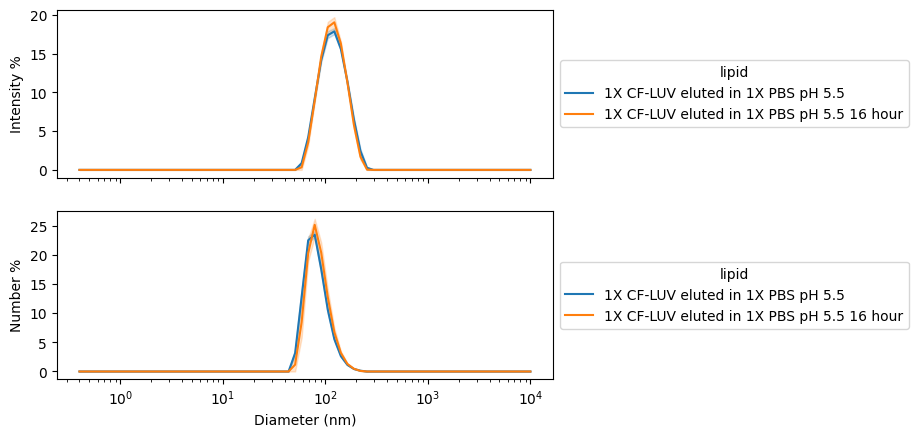

In [396]:
LUV = 1
lipid = "POPC"
fluorophore = "CF"
pH = "5.5"
Triton = 0

temp_data = df_main[(df_main["LUV"] == LUV) &
                    (df_main["fluorophore"] == fluorophore) &
                    (df_main["pH"] == pH) &
                    (df_main["Triton"] == Triton)]

for lipid in temp_data["lipid"].dropna().unique():
    print(lipid)
    
    fig, ax = plt.subplots(2,1, sharex=True)

    sns.lineplot(data=temp_data[temp_data["lipid"] == lipid],
                 x="Diameter (nm)",
                 y="Intensity %",
                 hue="title",
                 ax=ax[0])

    sns.lineplot(data=temp_data[temp_data["lipid"] == lipid],
                 x="Diameter (nm)",
                 y="Number %",
                 hue="title",
                 ax=ax[1])

    ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="lipid")
    ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="lipid")

    ax[0].set_xscale('log')

In [247]:
df_main.loc[:,["title", "LUV","LNP","lipid"]]

,title,LUV,LNP,lipid
0,1X CF-LUV eluted in 1X PBS pH 5.5,1,0,NaN
1,1X CF-LUV eluted in 1X PBS pH 5.5,1,0,NaN
2,1X CF-LUV eluted in 1X PBS pH 5.5,1,0,NaN
3,1X CF-LUV eluted in 1X PBS pH 5.5,1,0,NaN
4,1X CF-LUV eluted in 1X PBS pH 5.5,1,0,NaN
...,...,...,...,...
86375,Sample C - CF-LUV + PBS (avg),1,0,NaN
86376,Sample C - CF-LUV + PBS (avg),1,0,NaN
86377,Sample C - CF-LUV + PBS (avg),1,0,NaN
86378,Sample C - CF-LUV + PBS (avg),1,0,NaN


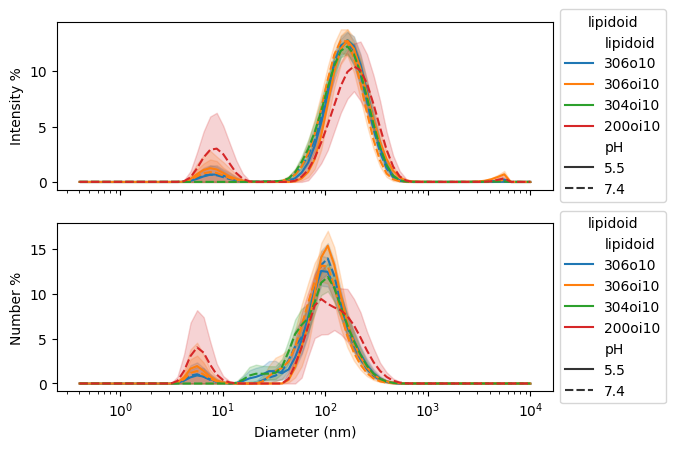

In [379]:
fig, ax = plt.subplots(2,1, sharex=True)

temp_data = df_main[df_main['lipidoid'].notna()]

sns.lineplot(data=temp_data,
             x="Diameter (nm)",
             y="Intensity %",
             hue="lipidoid",
             style="pH",
             ax=ax[0])

sns.lineplot(data=temp_data,
             x="Diameter (nm)",
             y="Number %",
             hue="lipidoid",
             style="pH",
             ax=ax[1])

ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="lipidoid")
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="lipidoid")

ax[0].set_xscale('log')

# Compute Peak Diameter (mode) for each `id` 

In [380]:
# aggfunc finds the index of the maximum value for intensity and number columns, then uses index to find the diameter at which the max is found
df_pivot = pd.pivot_table(data=df_main,
               index='id',
               values = ["Intensity %","Number %"],
               aggfunc = [lambda x: df_main.loc[x.idxmax(0),"Diameter (nm)"]]
              )

# format column names
df_pivot.columns = ["Peak Diameter by " + a[1] for a in df_pivot.columns.to_flat_index()]

df_pivot

,Peak Diameter by Intensity %,Peak Diameter by Number %
id,,
0,190.10,32.67
1,91.28,58.77
2,91.28,58.77
3,91.28,58.77
4,91.28,58.77
...,...,...
59,164.20,91.28
60,164.20,91.28
61,164.20,105.70


In [381]:
# merge back in to df_main
df_main = df_main.merge(df_pivot, left_on="id", right_on="id")
df_main

,DLS index,Record Number,Intensity %,Number %,Diameter (nm),Log Diameter,Measurement Date and Time,Sample Name,Triplicate,title,...,date,id,start date,days since,fluorophore,lipid,lipidoid,pH,Peak Diameter by Intensity %,Peak Diameter by Number %
0,1,4.0,0.0,0.0,0.4,-0.397940,"Wednesday, March 01, 2023 7:29:49 PM",N:P 1:1 LNP 0.1X 1,1,N:P 1:1 LNP 0.1X,...,2023-03-01,0,2023-03-01,0,NaN,NaN,NaN,7.4,190.10,32.67
1,1,4.0,0.0,0.0,0.4,-0.397940,"Wednesday, March 01, 2023 7:29:49 PM",N:P 1:1 LNP 0.1X 1,1,N:P 1:1 LNP 0.1X,...,2023-03-01,0,2023-03-01,0,NaN,NaN,NaN,7.4,190.10,32.67
2,1,4.0,0.0,0.0,0.4,-0.397940,"Wednesday, March 01, 2023 7:29:49 PM",N:P 1:1 LNP 0.1X 1,1,N:P 1:1 LNP 0.1X,...,2023-03-01,0,2023-03-01,0,NaN,NaN,NaN,7.4,190.10,32.67
3,1,4.0,0.0,0.0,0.4,-0.397940,"Wednesday, March 01, 2023 7:29:49 PM",N:P 1:1 LNP 0.1X 1,1,N:P 1:1 LNP 0.1X,...,2023-03-01,0,2023-03-01,0,NaN,NaN,NaN,7.4,190.10,32.67
4,1,4.0,0.0,0.0,0.4,-0.397940,"Wednesday, March 01, 2023 7:29:49 PM",N:P 1:1 LNP 0.1X 1,1,N:P 1:1 LNP 0.1X,...,2023-03-01,0,2023-03-01,0,NaN,NaN,NaN,7.4,190.10,32.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63275,66,63.0,0.0,0.0,5560.0,3.745075,"Tuesday, July 25, 2023 6:31:22 PM",CF POPG LUV 1X 3,3,CF POPG LUV 1X,...,2023-07-24,63,2023-03-01,145,CF,POPG,NaN,7.4,91.28,50.75
63276,67,63.0,0.0,0.0,6439.0,3.808818,"Tuesday, July 25, 2023 6:31:22 PM",CF POPG LUV 1X 3,3,CF POPG LUV 1X,...,2023-07-24,63,2023-03-01,145,CF,POPG,NaN,7.4,91.28,50.75
63277,68,63.0,0.0,0.0,7456.0,3.872506,"Tuesday, July 25, 2023 6:31:22 PM",CF POPG LUV 1X 3,3,CF POPG LUV 1X,...,2023-07-24,63,2023-03-01,145,CF,POPG,NaN,7.4,91.28,50.75
63278,69,63.0,0.0,0.0,8635.0,3.936262,"Tuesday, July 25, 2023 6:31:22 PM",CF POPG LUV 1X 3,3,CF POPG LUV 1X,...,2023-07-24,63,2023-03-01,145,CF,POPG,NaN,7.4,91.28,50.75


In [382]:
'''fig, ax = plt.subplots(2, sharex=True)

# plot peak diameter by intensity
sns.barplot(data=df_main,
            x="title",
            y="Peak Diameter by Intensity %",
            hue="days since",
           ax=ax[0])

ax[0].set_ylabel('Peak Diameter (nm) \n by Intensity %')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="days old")

# plot peak diameter by number
sns.barplot(data=df_main,
            x="title",
            y="Peak Diameter by Number %",
            hue="days since",
            ax=ax[1])

ax[1].set_ylabel('Peak Diameter (nm) \n by Number %')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="days old")

plt.xticks(rotation = 45)

plt.tight_layout()
'''

'fig, ax = plt.subplots(2, sharex=True)\n\n# plot peak diameter by intensity\nsns.barplot(data=df_main,\n            x="title",\n            y="Peak Diameter by Intensity %",\n            hue="days since",\n           ax=ax[0])\n\nax[0].set_ylabel(\'Peak Diameter (nm) \n by Intensity %\')\nax[0].legend(loc=\'center left\', bbox_to_anchor=(1, 0.5), title="days old")\n\n# plot peak diameter by number\nsns.barplot(data=df_main,\n            x="title",\n            y="Peak Diameter by Number %",\n            hue="days since",\n            ax=ax[1])\n\nax[1].set_ylabel(\'Peak Diameter (nm) \n by Number %\')\nax[1].legend(loc=\'center left\', bbox_to_anchor=(1, 0.5), title="days old")\n\nplt.xticks(rotation = 45)\n\nplt.tight_layout()\n'

ValueError: Could not interpret input 'Peak Diameter by Intensity %'

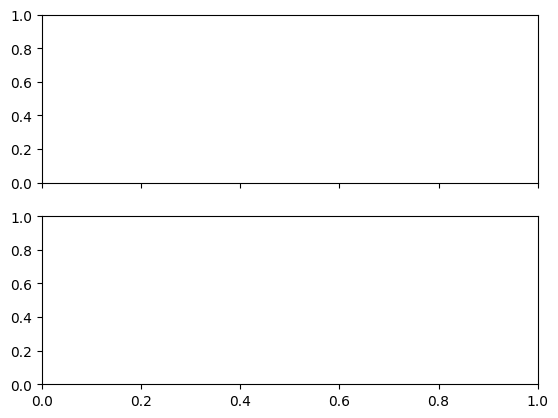

In [383]:
fig, ax = plt.subplots(2, sharex=True)

# plot peak diameter by intensity
sns.barplot(data=temp_data,
            x="lipidoid",
            y="Peak Diameter by Intensity %",
            hue="pH",
           ax=ax[0])

ax[0].set_ylabel('Peak Diameter (nm) \n by Intensity %')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="days old")

# plot peak diameter by number
sns.barplot(data=temp_data,
            x="lipidoid",
            y="Peak Diameter by Number %",
            hue="pH",
            ax=ax[1])

ax[1].set_ylabel('Peak Diameter (nm) \n by Number %')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="days old")

plt.xticks(rotation = 45)

plt.tight_layout()

# Compute weighted average intensity and number

In [384]:
# prepare temporary dataframe for calculation
df_rn = pd.DataFrame(df_main["Record Number"].drop_duplicates()).set_index("Record Number")

# for each unique record number, compute the weighted average intensity and number
for rn in df_rn.index:
    rn_sum_prod_int = df_main.loc[df_main["Record Number"] == rn].loc[:,["Intensity %","Diameter (nm)"]].product(axis=1).sum()
    rn_sum_prod_num = df_main.loc[df_main["Record Number"] == rn].loc[:,["Number %","Diameter (nm)"]].product(axis=1).sum()
    rn_sum_weights_int = df_main.loc[df_main["Record Number"] == rn].loc[:,["Intensity %"]].sum().values
    rn_sum_weights_num = df_main.loc[df_main["Record Number"] == rn].loc[:,["Number %"]].sum().values

    # assign value in df_rn
    df_rn.loc[rn,"Weighted Average Intensity"] = rn_sum_prod_int / rn_sum_weights_int
    df_rn.loc[rn,"Weighted Average Number"] = rn_sum_prod_num / rn_sum_weights_num

# merge back in to df_main  
df_main = df_main.merge(df_rn, left_on="Record Number", right_on=df_rn.index)
df_main

,DLS index,Record Number,Intensity %,Number %,Diameter (nm),Log Diameter,Measurement Date and Time,Sample Name,Triplicate,title,...,start date,days since,fluorophore,lipid,lipidoid,pH,Peak Diameter by Intensity %,Peak Diameter by Number %,Weighted Average Intensity,Weighted Average Number
0,1,4.0,0.0,0.0,0.4,-0.397940,"Wednesday, March 01, 2023 7:29:49 PM",N:P 1:1 LNP 0.1X 1,1,N:P 1:1 LNP 0.1X,...,2023-03-01,0,NaN,NaN,NaN,7.4,190.10,32.67,165.2857,98.574716
1,1,4.0,0.0,0.0,0.4,-0.397940,"Wednesday, March 01, 2023 7:29:49 PM",N:P 1:1 LNP 0.1X 1,1,N:P 1:1 LNP 0.1X,...,2023-03-01,0,NaN,NaN,NaN,7.4,190.10,32.67,165.2857,98.574716
2,1,4.0,0.0,0.0,0.4,-0.397940,"Wednesday, March 01, 2023 7:29:49 PM",N:P 1:1 LNP 0.1X 1,1,N:P 1:1 LNP 0.1X,...,2023-03-01,0,NaN,NaN,NaN,7.4,190.10,32.67,165.2857,98.574716
3,1,4.0,0.0,0.0,0.4,-0.397940,"Wednesday, March 01, 2023 7:29:49 PM",N:P 1:1 LNP 0.1X 1,1,N:P 1:1 LNP 0.1X,...,2023-03-01,0,NaN,NaN,NaN,7.4,190.10,32.67,165.2857,98.574716
4,1,4.0,0.0,0.0,0.4,-0.397940,"Wednesday, March 01, 2023 7:29:49 PM",N:P 1:1 LNP 0.1X 1,1,N:P 1:1 LNP 0.1X,...,2023-03-01,0,NaN,NaN,NaN,7.4,190.10,32.67,165.2857,98.574716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63275,66,63.0,0.0,0.0,5560.0,3.745075,"Tuesday, July 25, 2023 6:31:22 PM",CF POPG LUV 1X 3,3,CF POPG LUV 1X,...,2023-03-01,145,CF,POPG,NaN,7.4,91.28,50.75,98.3694,60.093146
63276,67,63.0,0.0,0.0,6439.0,3.808818,"Tuesday, July 25, 2023 6:31:22 PM",CF POPG LUV 1X 3,3,CF POPG LUV 1X,...,2023-03-01,145,CF,POPG,NaN,7.4,91.28,50.75,98.3694,60.093146
63277,68,63.0,0.0,0.0,7456.0,3.872506,"Tuesday, July 25, 2023 6:31:22 PM",CF POPG LUV 1X 3,3,CF POPG LUV 1X,...,2023-03-01,145,CF,POPG,NaN,7.4,91.28,50.75,98.3694,60.093146
63278,69,63.0,0.0,0.0,8635.0,3.936262,"Tuesday, July 25, 2023 6:31:22 PM",CF POPG LUV 1X 3,3,CF POPG LUV 1X,...,2023-03-01,145,CF,POPG,NaN,7.4,91.28,50.75,98.3694,60.093146


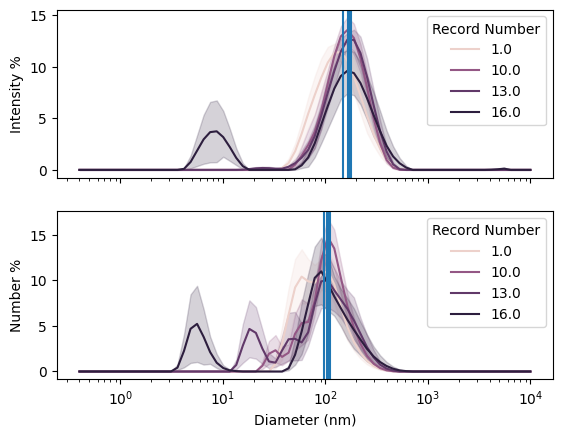

In [385]:
fig, ax = plt.subplots(2,1,sharex=True)

sns.lineplot(data=df_main[df_main["Record Number"].isin([1,10,13,16])],
             x="Diameter (nm)",
             y="Intensity %",
             hue="Record Number",
             ax=ax[0])

for rn in [1,10,13,16]:
    ax[0].axvline(x=df_main[df_main["Record Number"] == rn].loc[:,"Weighted Average Intensity"].drop_duplicates().values)
    
sns.lineplot(data=df_main[df_main["Record Number"].isin([1,10,13,16])],
             x="Diameter (nm)",
             y="Number %",
             hue="Record Number",
             ax=ax[1])

for rn in [1,10,13,16]:
    ax[1].axvline(x=df_main[df_main["Record Number"] == rn].loc[:,"Weighted Average Number"].drop_duplicates().values)


ax[0].set_xscale('log')



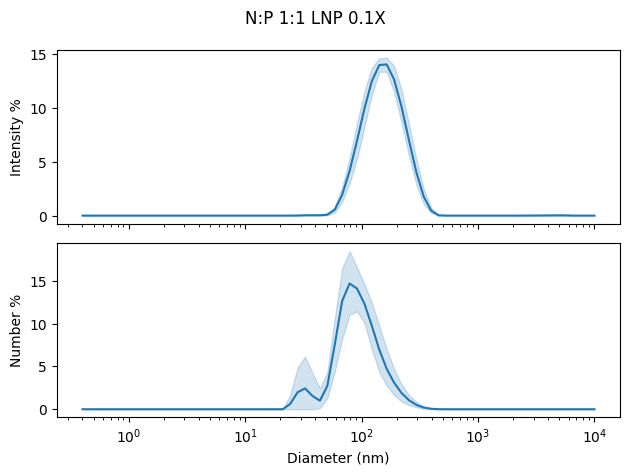

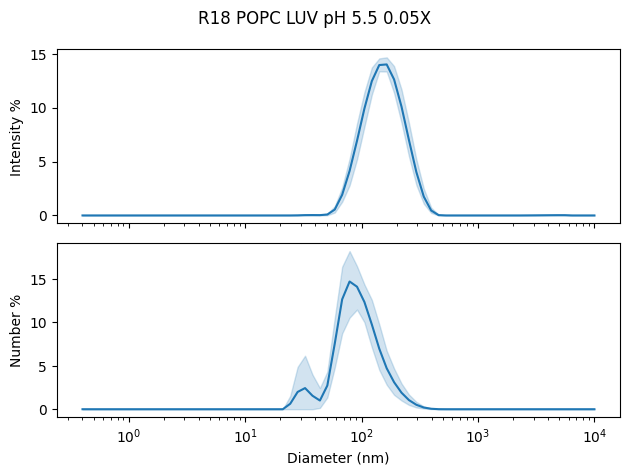

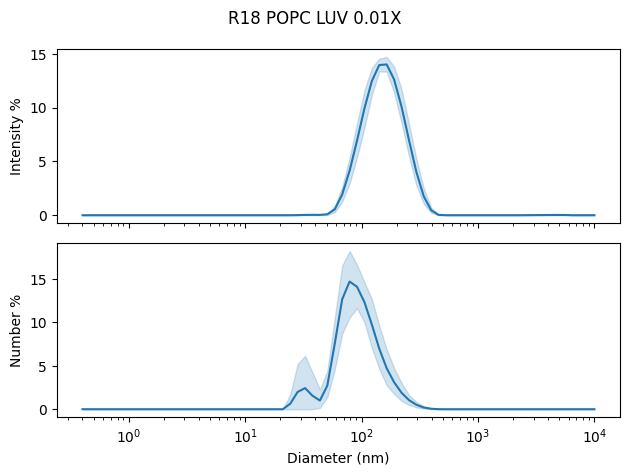

In [387]:
for title in df_main["title"].unique()[0:3]:

    fig, ax = plt.subplots(2,1,sharex=True)

    sns.lineplot(data=df_main[df_main["title"] == title],
                 x="Diameter (nm)",
                 y="Intensity %",
                 ax=ax[0])

    sns.lineplot(data=df_main[df_main["title"] == title],
                 x="Diameter (nm)",
                 y="Number %",
                 ax=ax[1])

    ax[0].set_xscale('log')
    plt.suptitle(title)
    plt.tight_layout()



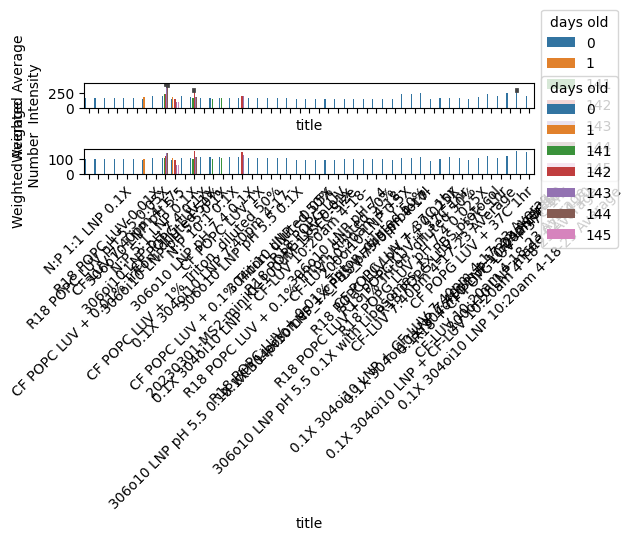

In [388]:
fig, ax = plt.subplots(2, sharex=True)

# plot peak diameter by intensity
sns.barplot(data=df_main,
            x="title",
            y="Weighted Average Intensity",
            hue="days since",
           ax=ax[0])

ax[0].set_ylabel('Weighted Average \n Intensity')
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="days old")

# plot peak diameter by number
sns.barplot(data=df_main,
            x="title",
            y="Weighted Average Number",
            hue="days since",
            ax=ax[1])

ax[1].set_ylabel('Weighted Average \n Number')
ax[1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="days old")

plt.xticks(rotation = 45)

plt.tight_layout()

# Fit Gaussian to curves

## Generate fitted parameters (a, x0, sigma)

In [389]:
# Define Gaussian function that we will fit to
def Gauss(x, a, x0, sigma):
    # a = maximum 
    # x0 = mean
    # sigma = standard of deviation
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# initial guess for data
p0_guess = p0=[10,2,1]

In [390]:
for rn in df_rn.index:
    
    for datatype in ["Intensity","Number"]:

        # extract dataframe for this record number
        df_temp = df_main.loc[df_main["Record Number"]==rn].loc[:,["Log Diameter",datatype + " %"]].copy(deep=True)

        # Execute Curve Fit
        popt, pcov = curve_fit(Gauss, 
                               df_temp["Log Diameter"].values, 
                               df_temp[datatype + " %"].values,
                               p0=p0_guess)

        # load Optimized values into df_rn
        df_rn.loc[rn,["a "+datatype,"log10 x0 "+datatype,"log10 sigma "+datatype]] = popt
        
        # generate new fitted data
        yfit = Gauss(df_temp["Log Diameter"].values, 
                     popt[0], popt[1], popt[2])
        
        # load into df_temp, then join with df_main
        df_main.loc[df_temp.index,"Fitted "+datatype+" %"] = yfit

In [391]:
# calculate and load confidence interval data into df_rn
for datatype in ["Intensity","Number"]:
    # convert x0 and sigma back to linear space
    df_rn.loc[:,"x0 "+datatype]    = np.power(10,df_rn.loc[:,"log10 x0 " + datatype])
    df_rn.loc[:,"sigma "+datatype] = np.power(10,df_rn.loc[:,"log10 sigma " + datatype])

    # calculate lower and upper bounds of confidence interval
    df_rn.loc[:,"lower "+datatype] = np.power(10, df_rn.loc[:,"log10 x0 " + datatype] - df_rn.loc[:,"log10 sigma " + datatype])
    df_rn.loc[:,"upper "+datatype] = np.power(10, df_rn.loc[:,"log10 x0 " + datatype] + df_rn.loc[:,"log10 sigma " + datatype])

    # calculate lower and upper error bars of confidence interval
    df_rn.loc[:,"lower err "+datatype] = df_rn.loc[:,"x0 "+datatype]      - df_rn.loc[:,"lower "+datatype]
    df_rn.loc[:,"upper err "+datatype] = df_rn.loc[:,"upper "+datatype] - df_rn.loc[:,"x0 "+datatype]

In [392]:
# merge all that new confidence interval information into df_main
df_main = df_main.merge(df_rn, left_on="Record Number", right_on=df_rn.index)

In [414]:
df_main.columns

Index(['DLS index', 'Record Number', 'Intensity %', 'Number %',
       'Diameter (nm)', 'Log Diameter', 'Measurement Date and Time',
       'Sample Name', 'Triplicate', 'title', 'time', 'date', 'id',
       'start date', 'days since', 'fluorophore', 'lipid', 'lipidoid', 'pH',
       'Peak Diameter by Intensity %', 'Peak Diameter by Number %',
       'Weighted Average Intensity_x', 'Weighted Average Number_x',
       'Fitted Intensity %', 'Fitted Number %', 'Weighted Average Intensity_y',
       'Weighted Average Number_y', 'a Intensity', 'log10 x0 Intensity',
       'log10 sigma Intensity', 'a Number', 'log10 x0 Number',
       'log10 sigma Number', 'x0 Intensity', 'sigma Intensity',
       'lower Intensity', 'upper Intensity', 'lower err Intensity',
       'upper err Intensity', 'x0 Number', 'sigma Number', 'lower Number',
       'upper Number', 'lower err Number', 'upper err Number'],
      dtype='object')

# Bar Graphs of Peak, Weighted Mean Diameter, and Fitted Mean Diameter

In [411]:
df_main.columns

Index(['DLS index', 'Record Number', 'Intensity %', 'Number %',
       'Diameter (nm)', 'Log Diameter', 'Measurement Date and Time',
       'Sample Name', 'Triplicate', 'title', 'time', 'date', 'id',
       'start date', 'days since', 'fluorophore', 'lipid', 'lipidoid', 'pH',
       'Peak Diameter by Intensity %', 'Peak Diameter by Number %',
       'Weighted Average Intensity_x', 'Weighted Average Number_x',
       'Fitted Intensity %', 'Fitted Number %', 'Weighted Average Intensity_y',
       'Weighted Average Number_y', 'a Intensity', 'log10 x0 Intensity',
       'log10 sigma Intensity', 'a Number', 'log10 x0 Number',
       'log10 sigma Number', 'x0 Intensity', 'sigma Intensity',
       'lower Intensity', 'upper Intensity', 'lower err Intensity',
       'upper err Intensity', 'x0 Number', 'sigma Number', 'lower Number',
       'upper Number', 'lower err Number', 'upper err Number'],
      dtype='object')

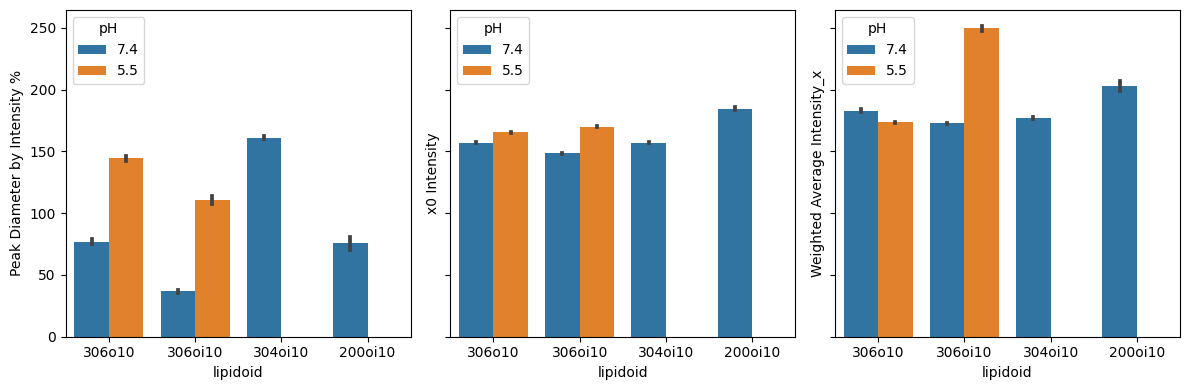

In [425]:
fig, ax = plt.subplots(1,3, figsize=(12,4), sharey=True)

var_id = 0

for variable in ['Peak Diameter by Intensity %', 'x0 Intensity', 'Weighted Average Intensity_x']:

    # plot peak diameter by intensity
    sns.barplot(data=df_main,
                x="lipidoid",
                y=variable,
                hue="pH",
               ax=ax[var_id])

    #ax[0,0].set_ylabel('Mean Diameter (nm) \n by Intensity %')
    #ax[0,0].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="pH")
    #plt.xticks(rotation = 45)
    var_id += 1
    
    plt.tight_layout()

# Plot spectra by lipidoid using seaborn

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


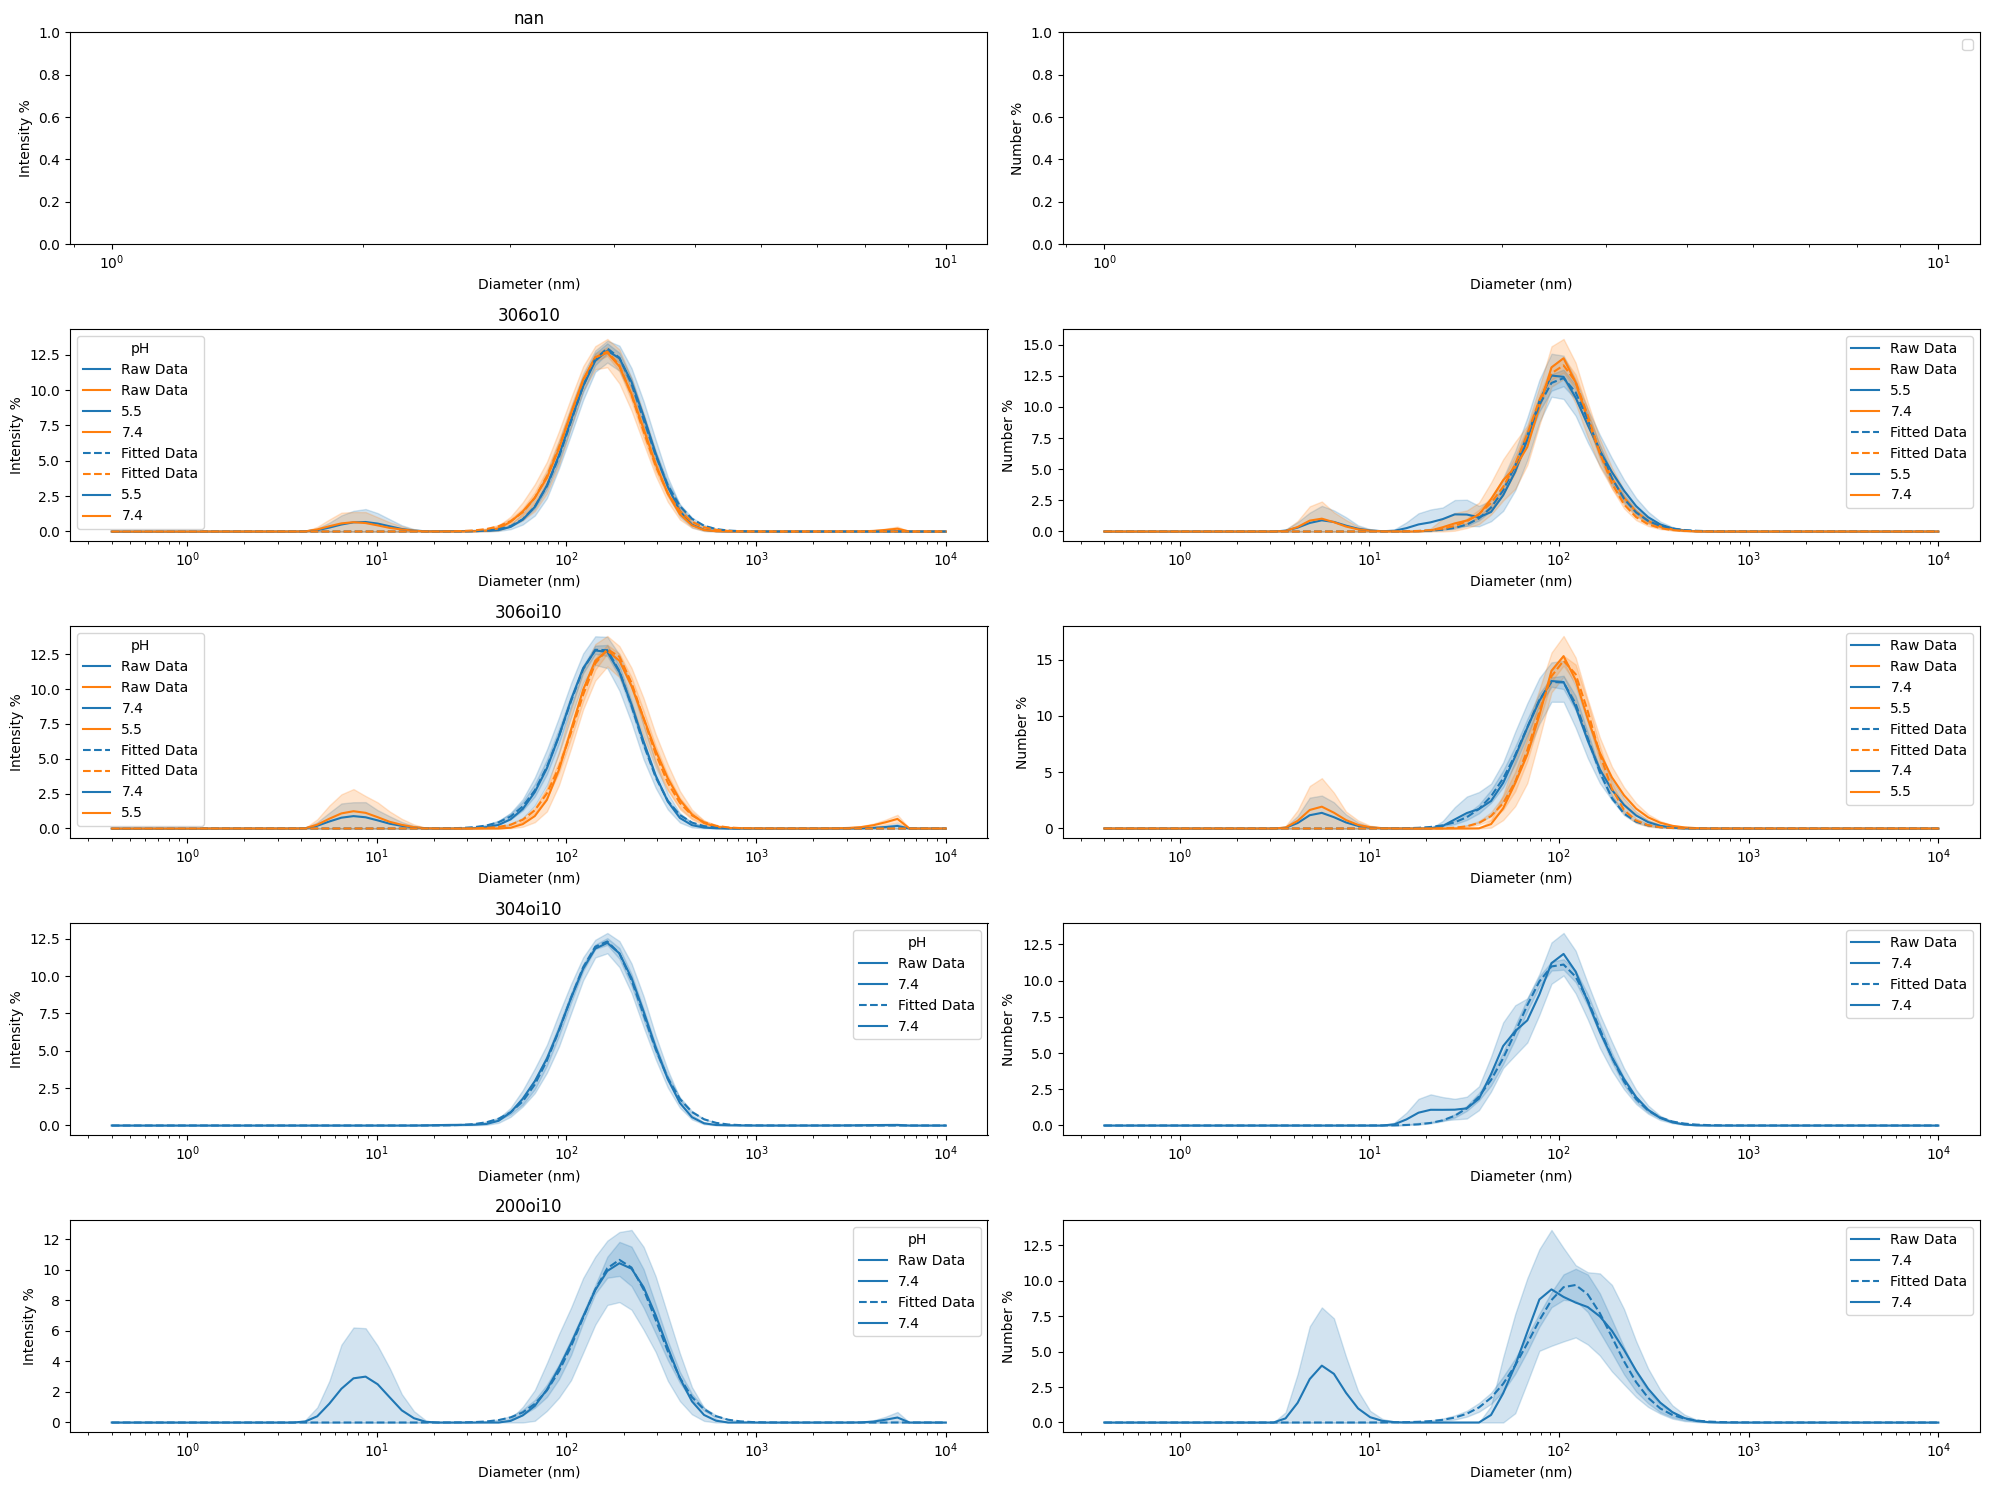

In [410]:
N = len(df_main["lipidoid"].unique())

fig, ax = plt.subplots(N,2, figsize=(20,N*3))

ax_id = 0

for lipidoid in df_main["lipidoid"].unique():
    
    # plot intensity data
    
    sns.lineplot(df_main.loc[df_main["lipidoid"]==lipidoid],
                 x="Diameter (nm)",
                 y="Intensity %",
                 label="Raw Data",
                 hue="pH",
                 ax=ax[ax_id,0])
    sns.lineplot(df_main.loc[df_main["lipidoid"]==lipidoid],
                 x="Diameter (nm)",
                 y="Fitted Intensity %",
                 label="Fitted Data",
                 hue="pH",
                 linestyle="dashed",
                 ax=ax[ax_id,0])

    # plot number data
    
    sns.lineplot(df_main.loc[df_main["lipidoid"]==lipidoid],
                 x="Diameter (nm)",
                 y="Number %",
                 label="Raw Data",
                 hue="pH",
                 ax=ax[ax_id,1])
    sns.lineplot(df_main.loc[df_main["lipidoid"]==lipidoid],
                 x="Diameter (nm)",
                 y="Fitted Number %",
                 label="Fitted Data",
                 hue="pH",
                 linestyle="dashed",
                 ax=ax[ax_id,1])

    # format axes
    
    ax[ax_id,0].set_xscale('log')
    ax[ax_id,1].set_xscale('log')
    
    ax[ax_id,0].set_title(lipidoid)
    
    ax[ax_id,0].set_ylabel('Intensity %')
    ax[ax_id,1].set_ylabel('Number %')
    
    ax[ax_id,0].set_xlabel('Diameter (nm)')
    ax[ax_id,1].set_xlabel('Diameter (nm)')
    
    # format legend
    
    ax[ax_id,1].legend()
    
    # format text
    '''
    ax[rn-1,0].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Intensity %"].max(),
                  "mean = " + "{:.2f}".format(df_main.loc[rn,"x0 Intensity"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Intensity"]))

    ax[rn-1,1].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Number %"].max(),
                  "mean = " + "{:.2f}".format(df_rn.loc[rn,"x0 Number"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Number"]))
    '''
    
    ax_id += 1
    
plt.tight_layout()

# Plot spectra by lipidoid using matplotlib

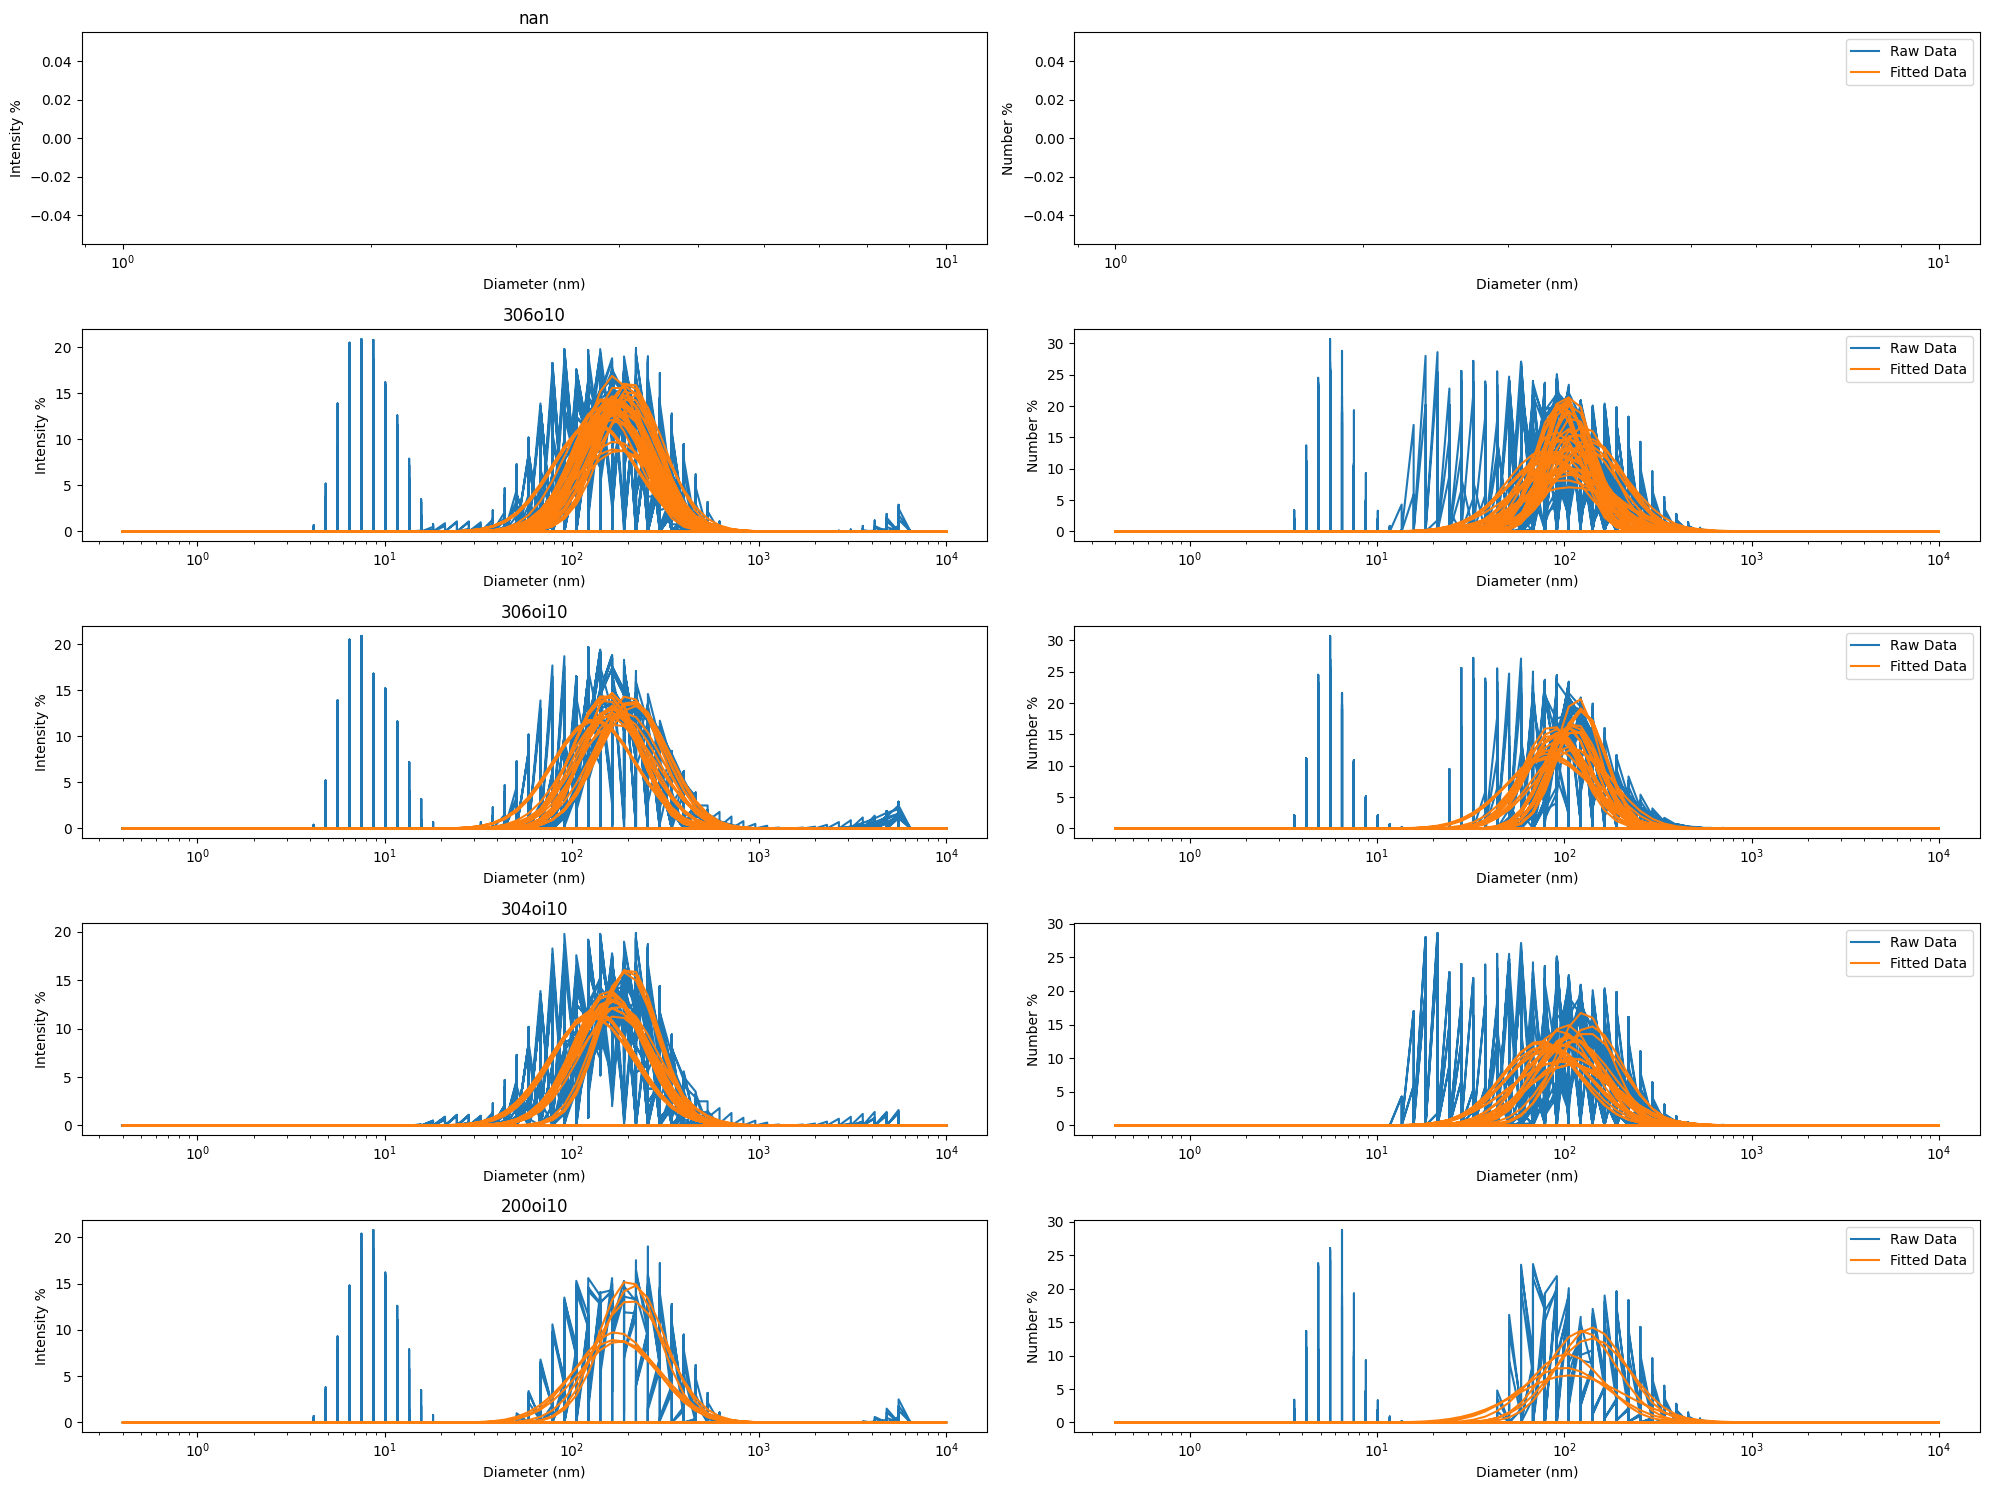

In [409]:
N = len(df_main["lipidoid"].unique())

fig, ax = plt.subplots(N,2, figsize=(20,N*3))

ax_id = 0

for lipidoid in df_main["lipidoid"].unique():
    
    # plot intensity data
    
    ax[ax_id,0].plot(df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Diameter (nm)"],
                   df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Intensity %"],
                   label="Raw Data")
    ax[ax_id,0].plot(df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Fitted Intensity %"],
                  label="Fitted Data")
    
    # plot number data
    
    ax[ax_id,1].plot(df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Number %"],
                  label="Raw Data")
    ax[ax_id,1].plot(df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["lipidoid"]==lipidoid].loc[:,"Fitted Number %"],
                  label="Fitted Data")

    # format axes
    
    ax[ax_id,0].set_xscale('log')
    ax[ax_id,1].set_xscale('log')
    
    ax[ax_id,0].set_title(lipidoid)
    
    ax[ax_id,0].set_ylabel('Intensity %')
    ax[ax_id,1].set_ylabel('Number %')
    
    ax[ax_id,0].set_xlabel('Diameter (nm)')
    ax[ax_id,1].set_xlabel('Diameter (nm)')
    
    # format legend
    
    ax[ax_id,1].legend()
    
    # format text
    '''
    ax[rn-1,0].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Intensity %"].max(),
                  "mean = " + "{:.2f}".format(df_main.loc[rn,"x0 Intensity"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Intensity"]))

    ax[rn-1,1].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Number %"].max(),
                  "mean = " + "{:.2f}".format(df_rn.loc[rn,"x0 Number"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Number"]))
    '''
    
    ax_id += 1
    
plt.tight_layout()

## Plot fitted and raw data for every record number

In [ ]:
N = len(df_main["Record Number"].unique())

fig, ax = plt.subplots(N,2, figsize=(8,N*4))

for rn in df_main["Record Number"].unique():
    
    # plot intensity data
    
    ax[rn-1,0].plot(df_main.loc[df_main["Record Number"]==rn].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["Rrn*4ecord Number"]==rn].loc[:,"Intensity %"],
                  label="Raw Data")
    ax[rn-1,0].plot(df_main.loc[df_main["Record Number"]==rn].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["Record Number"]==rn].loc[:,"Fitted Intensity %"],
                  label="Fitted Data")

    # plot number data
    
    ax[rn-1,1].plot(df_main.loc[df_main["Record Number"]==rn].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["Record Number"]==rn].loc[:,"Number %"],
                  label="Raw Data")
    ax[rn-1,1].plot(df_main.loc[df_main["Record Number"]==rn].loc[:,"Diameter (nm)"],
                  df_main.loc[df_main["Record Number"]==rn].loc[:,"Fitted Number %"],
                  label="Fitted Data")

    # format axes
    
    ax[rn-1,0].set_xscale('log')
    ax[rn-1,1].set_xscale('log')
    
    ax[rn-1,0].set_title('Record Number '+str(rn))
    
    ax[rn-1,0].set_ylabel('Intensity %')
    ax[rn-1,1].set_ylabel('Number %')
    
    ax[rn-1,0].set_xlabel('Diameter (nm)')
    ax[rn-1,1].set_xlabel('Diameter (nm)')
    
    # format text
    
    ax[rn-1,0].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Intensity %"].max(),
                  "mean = " + "{:.2f}".format(df_main.loc[rn,"x0 Intensity"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Intensity"]))

    ax[rn-1,1].text(df_main["Diameter (nm)"].min(),
                  0.5*df_main.loc[df_main["Record Number"] == rn].loc[:,"Number %"].max(),
                  "mean = " + "{:.2f}".format(df_rn.loc[rn,"x0 Number"]) + "\n" + "$\sigma$ = " + "10^{:.2f}".format(df_rn.loc[rn,"sigma Number"]))

    plt.tight_layout()

In [ ]:
df_rn.head()

In [ ]:
df_rn

In [ ]:
np.shape(df_rn.loc[:,["lower err Intensity","upper err Intensity"]].values.T)

In [ ]:
fig, ax = plt.subplots()

plt.bar(df_rn.index,
        df_rn["x0 Intensity"],
        yerr=df_rn.loc[:,["lower err Intensity","upper err Intensity"]].values.T,
       capsize=4)

ax.set_xlabel('Record Number')
ax.set_ylabel('Mean Diameter (nm)')
#ax.set_yscale('log')
            

In [ ]:
fig, ax = plt.subplots()

sns.barplot(data=df_main,
            x="Record Number",
            y="x0 Intensity",
            hue="title",
            ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
for title in df_main["title"].unique():

    df_temp = df_main[df_main["title"] == title]
    
    fig, ax = plt.subplots()

    plt.bar(df_temp["days since"],
            df_temp["x0 Intensity"],
            yerr=df_temp.loc[:,["lower err Intensity","upper err Intensity"]].values.T,
           capsize=4)

    ax.set_xlabel('Record Number')
    ax.set_ylabel('Mean Diameter (nm)')
    ax.set_title(title)
            